In [1]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler  
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import scipy.stats as st
from sklearn import preprocessing
import plotly
from sklearn.preprocessing import StandardScaler  
from sklearn.tree import DecisionTreeClassifier
import plotly.plotly as py
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
import geohash as gh
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
# Read the data 
train_data = pd.read_csv('dataSet.csv')
zipCode_data = pd.read_csv('uszipsv1.4-2.csv')
weather_data = pd.read_csv('weather_description.csv')

In [3]:
# Dictionary for seasons
seasons_in_sf = {
    'January':'Winter',
    'February':'Winter',
    'March':'Spring',
    'April':'Spring',
    'May':'Spring',
    'June':'Summer',
    'July':'Summer',
    'August':'Summer',
    'September':'Fall',
    'October':'Fall',
    'November':'Fall',
    'December':'Winter'
}

In [4]:
# months: number to actual name
number_to_monthNames = {
    1:'January',
    2:'February',
    3:'March',
    4:'April',
    5:'May',
    6:'June',
    7:'July',
    8:'August',
    9:'September',
    10:'October',
    11:'November',
    12:'December'
}

In [5]:
# checking the train dataset
train_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [6]:
# Checking for any null values in the data set
train_data.isnull().any()

Dates         False
Category      False
Descript      False
DayOfWeek     False
PdDistrict    False
Resolution    False
Address       False
X             False
Y             False
dtype: bool

In [7]:
# Chceking for the data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [8]:
# describing the train data
train_data.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


In [9]:
# Spliting date and time
date_time = train_data['Dates'].str.split(' ', n=1, expand= True)

In [10]:
# Extracting the date and time
train_data['Date'] = date_time[0]
train_data['Time'] = date_time[1]

In [11]:
# Extracting the date and time
time = pd.DatetimeIndex(train_data['Time'])
train_data['Hour'] = time.hour

In [12]:
# Dividing the hours into four categories
train_data = train_data.assign(Day_Sessions=pd.cut(train_data['Hour'],[-1,6,12,17,20,25],labels=['Post-Midnight','Morning','Afternoon','Evening','Night']))

In [13]:
# Extacting the exact date
date = pd.DatetimeIndex(train_data['Date'])

In [14]:
# Obtaining the respective year, month and day
train_data['Year'] = date.year
train_data['Month'] = date.month
train_data['Day']= date.day

In [15]:
# Mapping the months to respective seasons
train_data['Season'] = train_data['Month'].map(number_to_monthNames)
train_data['Season'] = train_data['Season'].map(seasons_in_sf)

In [16]:
# Dropping one outlier
train_data = train_data[train_data.Y != 90]

In [17]:
train_data.shape

(877982, 17)

In [18]:
# Converting the latitude and longitude into geohash 5 as precision
train_data['geohash'] = train_data.apply(lambda x: gh.encode(x['Y'], x['X'], precision=5), axis=1)

In [19]:
# Since one of the hash coding and looking into the data, we know that it should match '9q8yp' we are filling na with this 
# geohash code as done below.
train_data['geohash'].fillna('9q8yp', inplace = True)

In [20]:
# reading the zip code data set.
zipCode_data.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,county_fips,county_name,all_county_weights,imprecise,military
0,501,40.8133,-73.0476,Holtsville,NY,New York,False,11742.0,NaN,NaN,NaN,NaN,True,False
1,544,40.8133,-73.0476,Holtsville,NY,New York,False,11742.0,NaN,NaN,NaN,NaN,True,False
2,601,18.1800,-66.7522,Adjuntas,PR,Puerto Rico,True,NaN,18570.0,72001.0,Adjuntas,"{'72001':99.43,'72141':0.57}",False,False
3,602,18.3607,-67.1752,Aguada,PR,Puerto Rico,True,NaN,41520.0,72003.0,Aguada,{'72003':100},False,False
4,603,18.4544,-67.1220,Aguadilla,PR,Puerto Rico,True,NaN,54689.0,72005.0,Aguadilla,{'72005':100},False,False


In [21]:
# Selecting only the zipcodes for the city San Francisco
zipCode_data = zipCode_data[zipCode_data.city == 'San Francisco']

In [22]:
# selecting only the required coloumns
zipCode_data = zipCode_data[['zip','lat','lng','population']]

In [23]:
# Performing the lat lan to geohash
zipCode_data['geohash'] = zipCode_data.apply(lambda x: gh.encode(x['lat'], x['lng'], precision=5), axis=1)

In [24]:
zipCode_data1 = zipCode_data

In [25]:
# filling the missing population using the interpolate method
zipCode_data1['population'] = zipCode_data1['population'].interpolate(method = 'linear')

In [26]:
train_data.shape

(877982, 18)

In [27]:
# Performing Inner join on County and State once standardized
train_data1 = pd.merge(train_data,zipCode_data1, how = 'inner',on = ['geohash'])

In [28]:
# removing duplicates after merging
res = train_data1[~train_data1[['Dates','X','Y','Descript']].apply(frozenset, axis=1).duplicated()]

In [29]:
res.isnull().sum(axis = 0)

Dates           0
Category        0
Descript        0
DayOfWeek       0
PdDistrict      0
Resolution      0
Address         0
X               0
Y               0
Date            0
Time            0
Hour            0
Day_Sessions    0
Year            0
Month           0
Day             0
Season          0
geohash         0
zip             0
lat             0
lng             0
population      0
dtype: int64

In [30]:
weather_data = weather_data[['datetime','San Francisco']]

In [31]:
weather_data['Dates'] = weather_data['datetime']

In [32]:
weather_date_time = weather_data['Dates'].str.split(' ', n=1, expand= True)

In [33]:
# Extracting the date and time
weather_data['Date'] = weather_date_time[0]
weather_data['Time'] = weather_date_time[1]

In [34]:
# Taking only the first occurance of the weather for that day.
weather_data['Date'].drop_duplicates( keep='first', inplace=True)

In [35]:
# Dropping the unwanted things from weather data frame
weather_data = weather_data.drop('datetime', axis=1)
weather_data = weather_data.drop('Dates', axis=1)
weather_data = weather_data.drop('Time', axis=1)

In [36]:
weather_data.head()

,San Francisco,Date
0,NaN,2012-10-01
1,light rain,2012-10-01
2,sky is clear,2012-10-01
3,sky is clear,2012-10-01
4,sky is clear,2012-10-01


In [37]:
weather_data['San Francisco'] = weather_data['San Francisco'].fillna(method = 'bfill')
weather_data['San Francisco'] = weather_data['San Francisco'].fillna(method = 'ffill')

In [38]:
# Performing Inner join to get the data on weather
train_data2 = pd.merge(res,weather_data, how = 'left', on = ['Date'])

In [39]:
# Removing the duplicates
res_final = train_data2[~train_data2[['Dates','X','Y','Descript']].apply(frozenset, axis=1).duplicated()]

In [40]:
# filling the weather report for unavailable data
res_final['San Francisco'] = res_final['San Francisco'].fillna(method = 'bfill')
res_final['San Francisco'] = res_final['San Francisco'].fillna(method = 'ffill')

In [41]:
# Renaming the feature
res_final.rename(columns={'San Francisco':'Weather Report'}, inplace=True)

In [89]:
train_data['Year'].unique()

array([2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005,
       2004, 2003], dtype=int64)

In [42]:
res_final.isnull().sum(axis = 0)

Dates             0
Category          0
Descript          0
DayOfWeek         0
PdDistrict        0
Resolution        0
Address           0
X                 0
Y                 0
Date              0
Time              0
Hour              0
Day_Sessions      0
Year              0
Month             0
Day               0
Season            0
geohash           0
zip               0
lat               0
lng               0
population        0
Weather Report    0
dtype: int64

# Dividing the crime into different classes

In [43]:
crime_category = {
    'LARCENY/THEFT' : 'Theft',
    'VEHICLE THEFT': 'Theft',
    'BURGLARY': 'Theft',
    'SEX OFFENSES FORCIBLE':'Sexual offences',
    'SEX OFFENSES NON FORCIBLE':'Sexual offences',
    'PORNOGRAPHY/OBSCENE MAT':'Sexual offences',
    'PROSTITUTION': 'Sexual offences',
    'DRUNKENNESS': 'Public order',
    'SUSPICIOUS OCC': 'Public order',
    'BRIBERY': 'Public order',
    'DRIVING UNDER THE INFLUENCE': 'Public order',
    'RECOVERED VEHICLE': 'Public order',
    'BAD CHECKS': 'Public order',
    'LOITERING':'Public order',
    'DISORDERLY CONDUCT':'Public order',
    'LIQUOR LAWS': 'Public order',
    'TRESPASS': 'Public order',
    'ROBBERY': 'Assault',
    'KIDNAPPING': 'Assault',
    'ASSAULT': 'Assault',
    'WEAPON LAWS':'Public order',
    'DRUG/NARCOTIC': 'Drug offences',
    'TREA': 'Property crime',
    'EMBEZZLEMENT': 'Property crime',
    'STOLEN PROPERTY':'Property crime',
    'VANDALISM': 'Property crime',
    'ARSON': 'Property crime',
    'FRAUD': 'White-collor crime',
    'FORGERY/COUNTERFEITING': 'White-collor crime',
    'SECONDARY CODES': 'White-collor crime',
    'GAMBLING': 'Victimless-crime',
    'RUNAWAY': 'Victimless-crime',
    'SUICIDE': 'Suicide',
    'FAMILY OFFENSES': 'Suicide',
    'MISSING PERSON': 'Suicide',
    'EXTORTION' :'Suicide',
    'WARRANTS': 'Other',
    'OTHER OFFENSES': 'Other',
    'NON-CRIMINAL':'Other'
}

In [44]:
res_final['Crime_Category'] = res_final['Category'].map(crime_category)

In [45]:
res_final['Crime_Category'].unique()

array(['Other', 'Property crime', 'Assault', 'Theft', 'Public order',
       'White-collor crime', 'Drug offences', 'Suicide',
       'Sexual offences', 'Victimless-crime'], dtype=object)

In [46]:
weather_category = {
    'few clouds':'Overcast', 'sky is clear':'Clear', 'light rain':'Rainy', 'scattered clouds':'Clear',
       'overcast clouds':'Overcast', 'broken clouds':'Overcast', 'moderate rain':'Rainy',
       'heavy intensity rain':'Rainy', 'proximity thunderstorm':'Rainy', 'thunderstorm':'Rainy',
       'mist':'Overcast', 'thunderstorm with rain':'Rainy', 'haze':'Overcast', 'fog':'Overcast',
       'proximity shower rain':'Rainy'
}

In [47]:
res_final['Weather Report'] = res_final['Weather Report'].map(weather_category)
res_final['Weather Report'].unique()

array(['Overcast', 'Clear', 'Rainy'], dtype=object)

In [48]:
# Checking if any missing values present 
res_final[pd.isnull(res_final).any(axis=1)]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Date,...,Month,Day,Season,geohash,zip,lat,lng,population,Weather Report,Crime_Category


# Encoding categorical values

In [49]:
# Encoding PD district
pd_dist = preprocessing.LabelEncoder()
pd_dist.fit(res_final.PdDistrict)
res_final['PdDistrict_LabelEncoded'] = pd_dist.transform(res_final.PdDistrict)

In [50]:
# Encoding Crime Category
crime_category = preprocessing.LabelEncoder()
crime_category.fit(res_final.Category)
res_final['Category_LabelEncoded'] = crime_category.transform(res_final.Category)

In [51]:
# Encoding Sessions 
day_session = preprocessing.LabelEncoder()
day_session.fit(res_final.Day_Sessions)
res_final['Session_LabelEncoded'] = day_session.transform(res_final.Day_Sessions)

In [52]:
# Encoding weather report
weather_report = preprocessing.LabelEncoder()
weather_report.fit(res_final['Weather Report'])
res_final['Weather_LabelEncoded'] = weather_report.transform(res_final['Weather Report'])

In [53]:
# Encoding Seasons
season_encode = preprocessing.LabelEncoder()
season_encode.fit(res_final['Season'])
res_final['season_LabelEncoded'] = season_encode.transform(res_final['Season'])

In [54]:
# Encoding Geo-hash codes
geohash_encode = preprocessing.LabelEncoder()
geohash_encode.fit(res_final['geohash'])
res_final['geohash_LabelEncoded'] = geohash_encode.transform(res_final['geohash'])

In [55]:
# Encoding Crime categories codes
crimeCategory_encode = preprocessing.LabelEncoder()
crimeCategory_encode.fit(res_final['Crime_Category'])
res_final['Crime_Category_LabelEncoded'] = crimeCategory_encode.transform(res_final['Crime_Category'])

# Visualization

In [ ]:
df = train_data.groupby(['Category'])['Year'].count().sort_values(ascending=False)[:39]
df.plot.bar(figsize = (25, 25))

In [ ]:
fig, axs = plt.subplots(ncols=1,nrows=1,figsize=(25,25))
sns.countplot(x=res_final["Crime_Category"])
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(12,12))
sns.countplot(x=res_final["Day_Sessions"],ax=axs[0,0])
sns.countplot(x=res_final["Weather Report"],ax=axs[0,1])
sns.countplot(x=res_final["Season"], ax=axs[1,0])
sns.countplot(x=res_final["DayOfWeek"], ax=axs[1,1])
plt.tight_layout()

In [ ]:
df = res_final.groupby(['PdDistrict'])['Category_LabelEncoded'].count()[:39]
df.plot.bar()

# Splitting the data

In [56]:
# partition dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(res_final[['PdDistrict_LabelEncoded','season_LabelEncoded','Weather_LabelEncoded','Session_LabelEncoded']],\
                                                    res_final['Crime_Category_LabelEncoded'], test_size=0.30, random_state = 0)

# Normalizing the Data

In [57]:
# standardize data
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train) 
x_test = scaler.transform(x_test)

#  k-Nearest Neighbors

In [58]:
# CLASSIFIER: k-Nearest Neighbors
# initialize k-nearest neighbors classifier
classifier = KNeighborsClassifier(n_neighbors = 10) 
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [59]:
# predict class labels using k-nearest neighbors classifier
y_pred = classifier.predict(x_test) 

In [60]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[ 3328  1346 14505   298   620     0   140 10489     0     0]
 [ 1538  2382  7838   107   191     0    45  3875     0     0]
 [ 7625  3962 38243   720  1294     0   451 25927     0     0]
 [ 1451   399  6864   223   356     0    86  6025     0     0]
 [ 2022   885  9470   208   403     0   117  6464     0     0]
 [  550   233  1668    24    29     0    13  1060     0     0]
 [  716   197  4000    75   138     0    92  2777     0     0]
 [ 6946  2238 34125  1059  1140     0   429 33454     0     0]
 [   60    21   292     5    12     0    13   196     0     0]
 [ 1056   355  5376    78   191     0   117  3945     0     0]]


Text(0.5,1,'Confusion matrix')

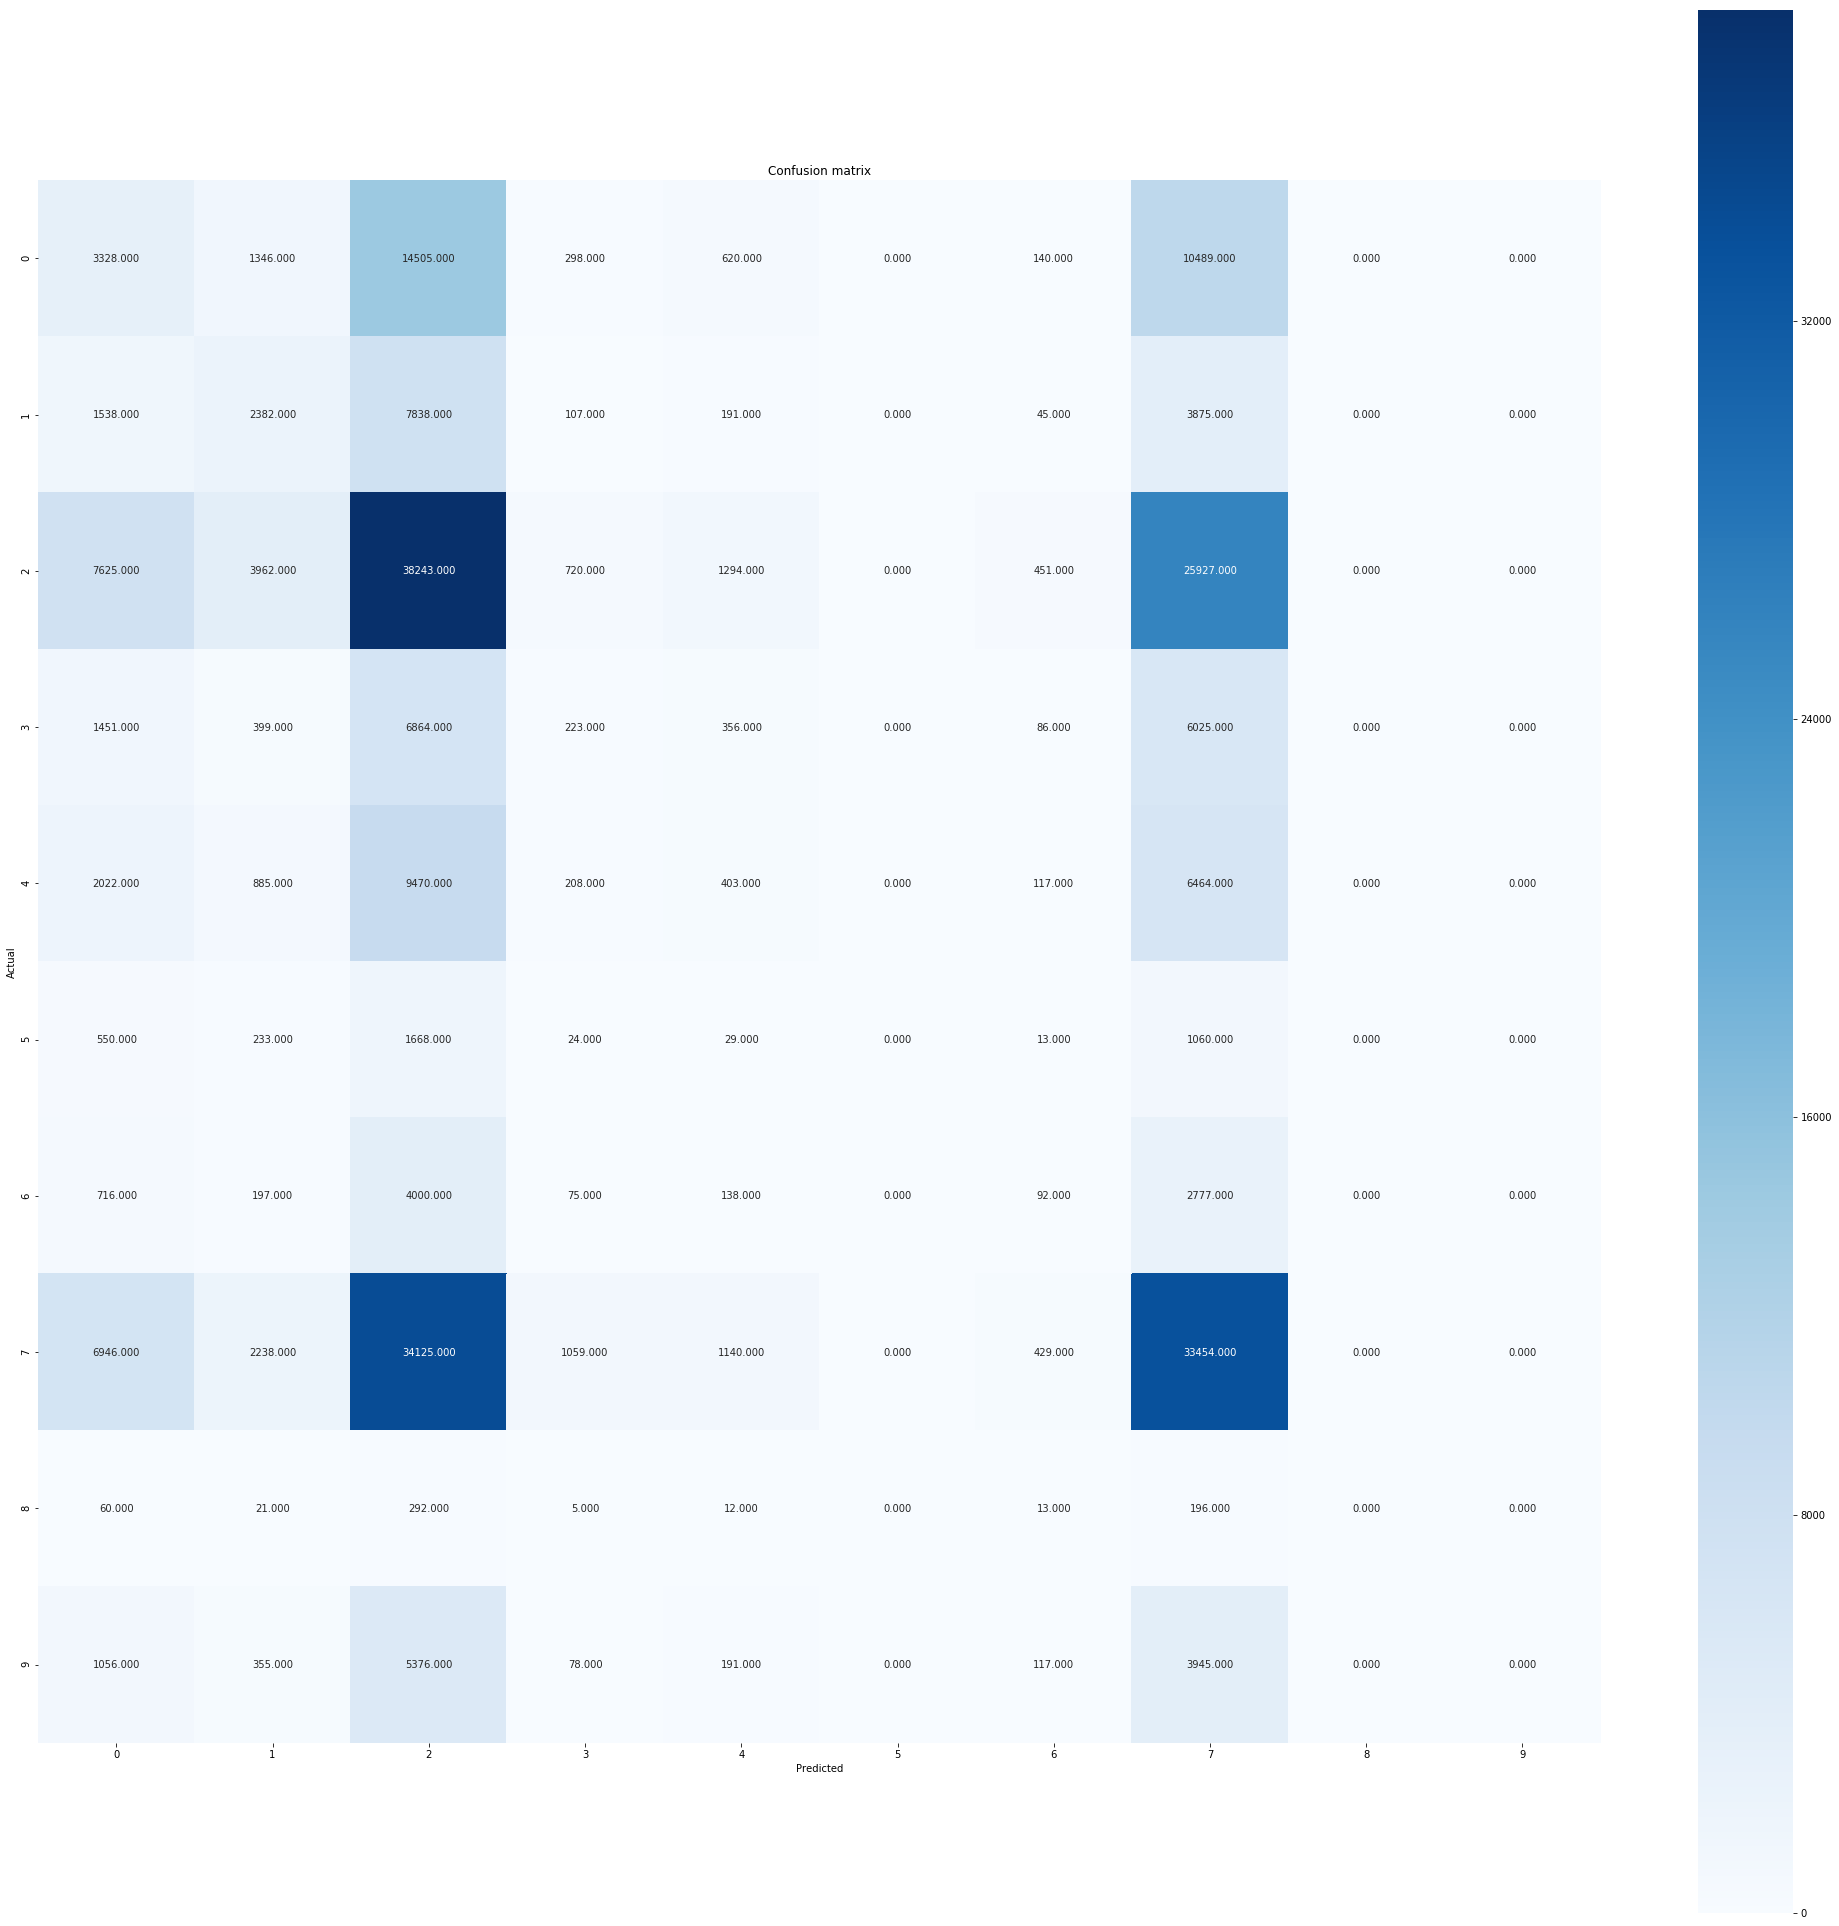

In [61]:
# plot confusion matrix
plt.subplots(figsize=(35,35))
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

In [62]:
# compute evaluation metrics
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.297531771632702
0.702468228367298
0.25624441256286706
0.31593356599523625
0.2749205150139882


# Decision Tree

In [63]:
model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 0)
scores = cross_val_score(model, x_train, y_train, cv=10, scoring='accuracy')
print(scores.mean())

0.3483651065696495


In [64]:
# build decision tree
model = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 0)
model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [65]:
# show decision tree
model.tree_.__getstate__()['nodes']
len(model.tree_.__getstate__()['nodes'])

1199

In [66]:
# predict class labels using decision tree
y_pred = model.predict(x_test)

In [67]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[    9     0 16261     0     0     0     0 14456     0     0]
 [    1     0 10714     0     0     0     0  5261     0     0]
 [   15     0 42294     0     0     0     0 35913     0     0]
 [    4     0  6635     0     0     0     0  8765     0     0]
 [    4     0 10604     0     0     0     0  8961     0     0]
 [    2     0  1870     0     0     0     0  1705     0     0]
 [    0     0  4387     0     0     0     0  3608     0     0]
 [   20     0 29594     0     0     0     0 49777     0     0]
 [    0     0   286     0     0     0     0   313     0     0]
 [    4     0  5789     0     0     0     0  5325     0     0]]


Text(0.5,1,'Confusion matrix')

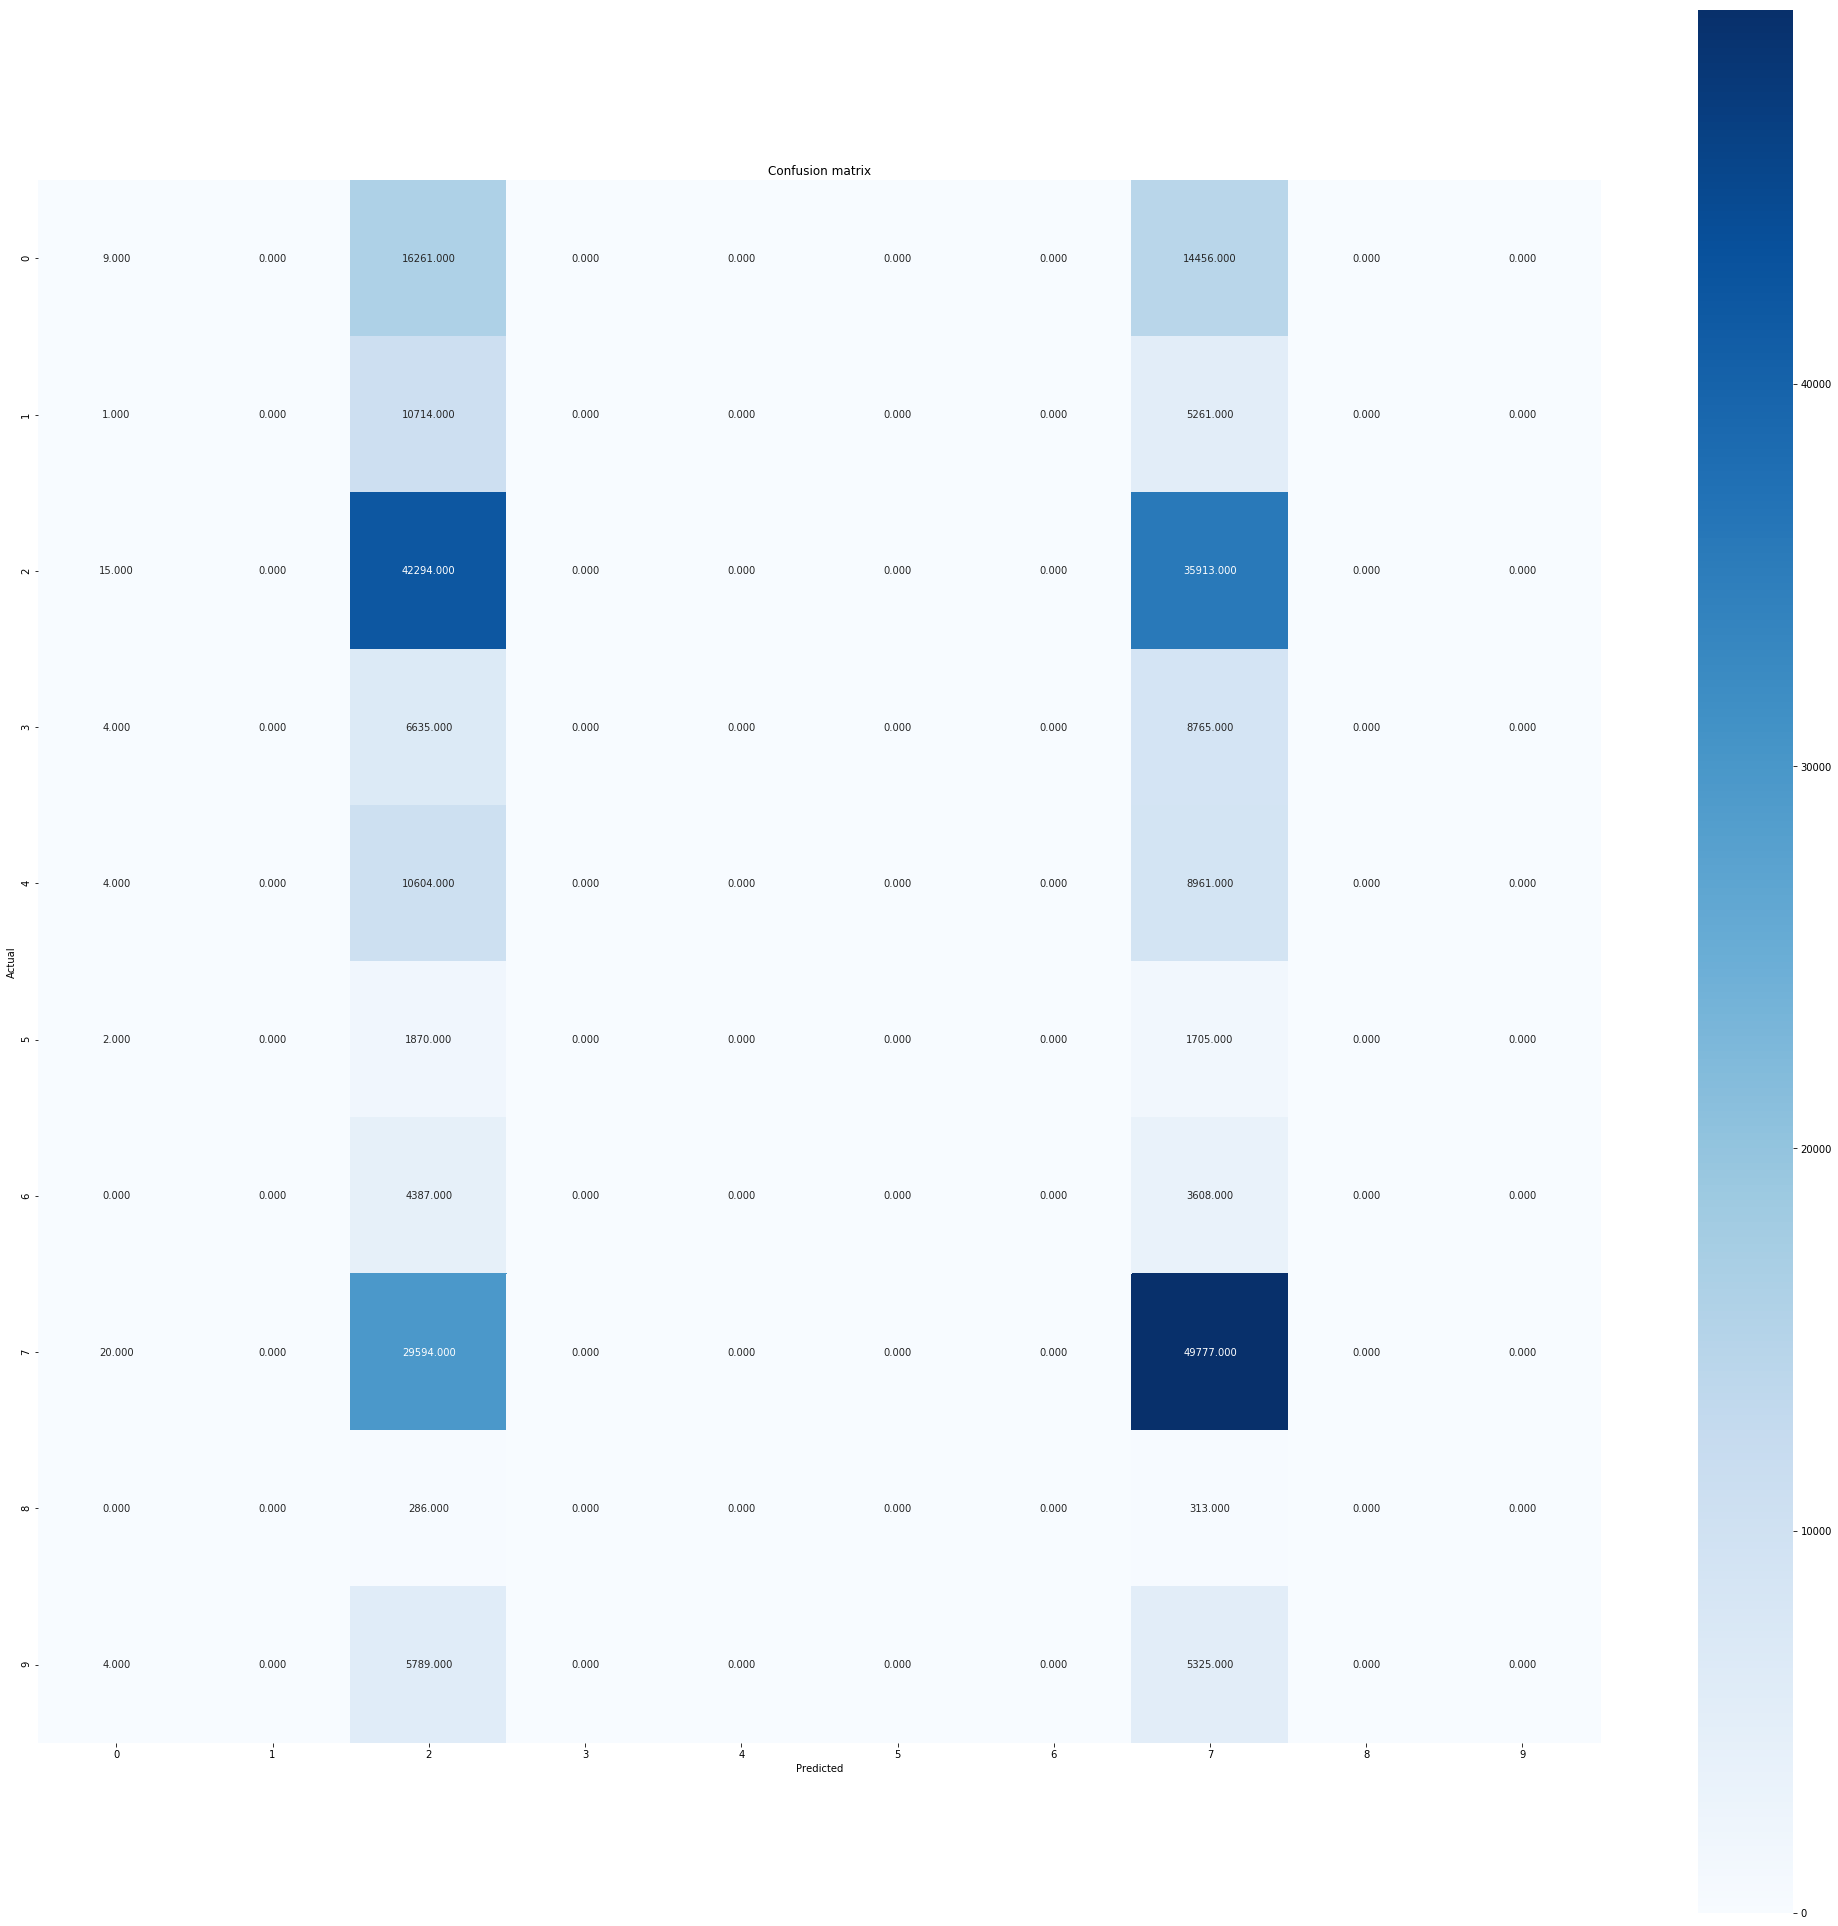

In [68]:
# plot confusion matrix
plt.subplots(figsize=(35,35))
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

In [69]:
# compute evaluation metrics
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.3506780868088218
0.6493219131911783
0.318143608476642
0.48890564354700833
0.3666771009191756


# Random Forest

In [70]:
# CLASSIFIER: Random forest
# build random forest
model = RandomForestClassifier(n_estimators = 256, criterion = "entropy", random_state = 0)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=256, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [71]:
# predict class labels using decision tree
y_pred = model.predict(x_test)

In [72]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[    3     0 16193     0     0     0     0 14530     0     0]
 [    0     0 10700     0     0     0     0  5276     0     0]
 [    5     0 42146     0     0     0     0 36071     0     0]
 [    1     0  6579     0     0     0     0  8824     0     0]
 [    1     0 10549     0     0     0     0  9019     0     0]
 [    0     0  1863     0     0     0     0  1714     0     0]
 [    0     0  4378     0     0     0     0  3617     0     0]
 [    8     0 29468     0     0     0     0 49915     0     0]
 [    0     0   286     0     0     0     0   313     0     0]
 [    3     0  5757     0     0     0     0  5358     0     0]]


Text(0.5,1,'Confusion matrix')

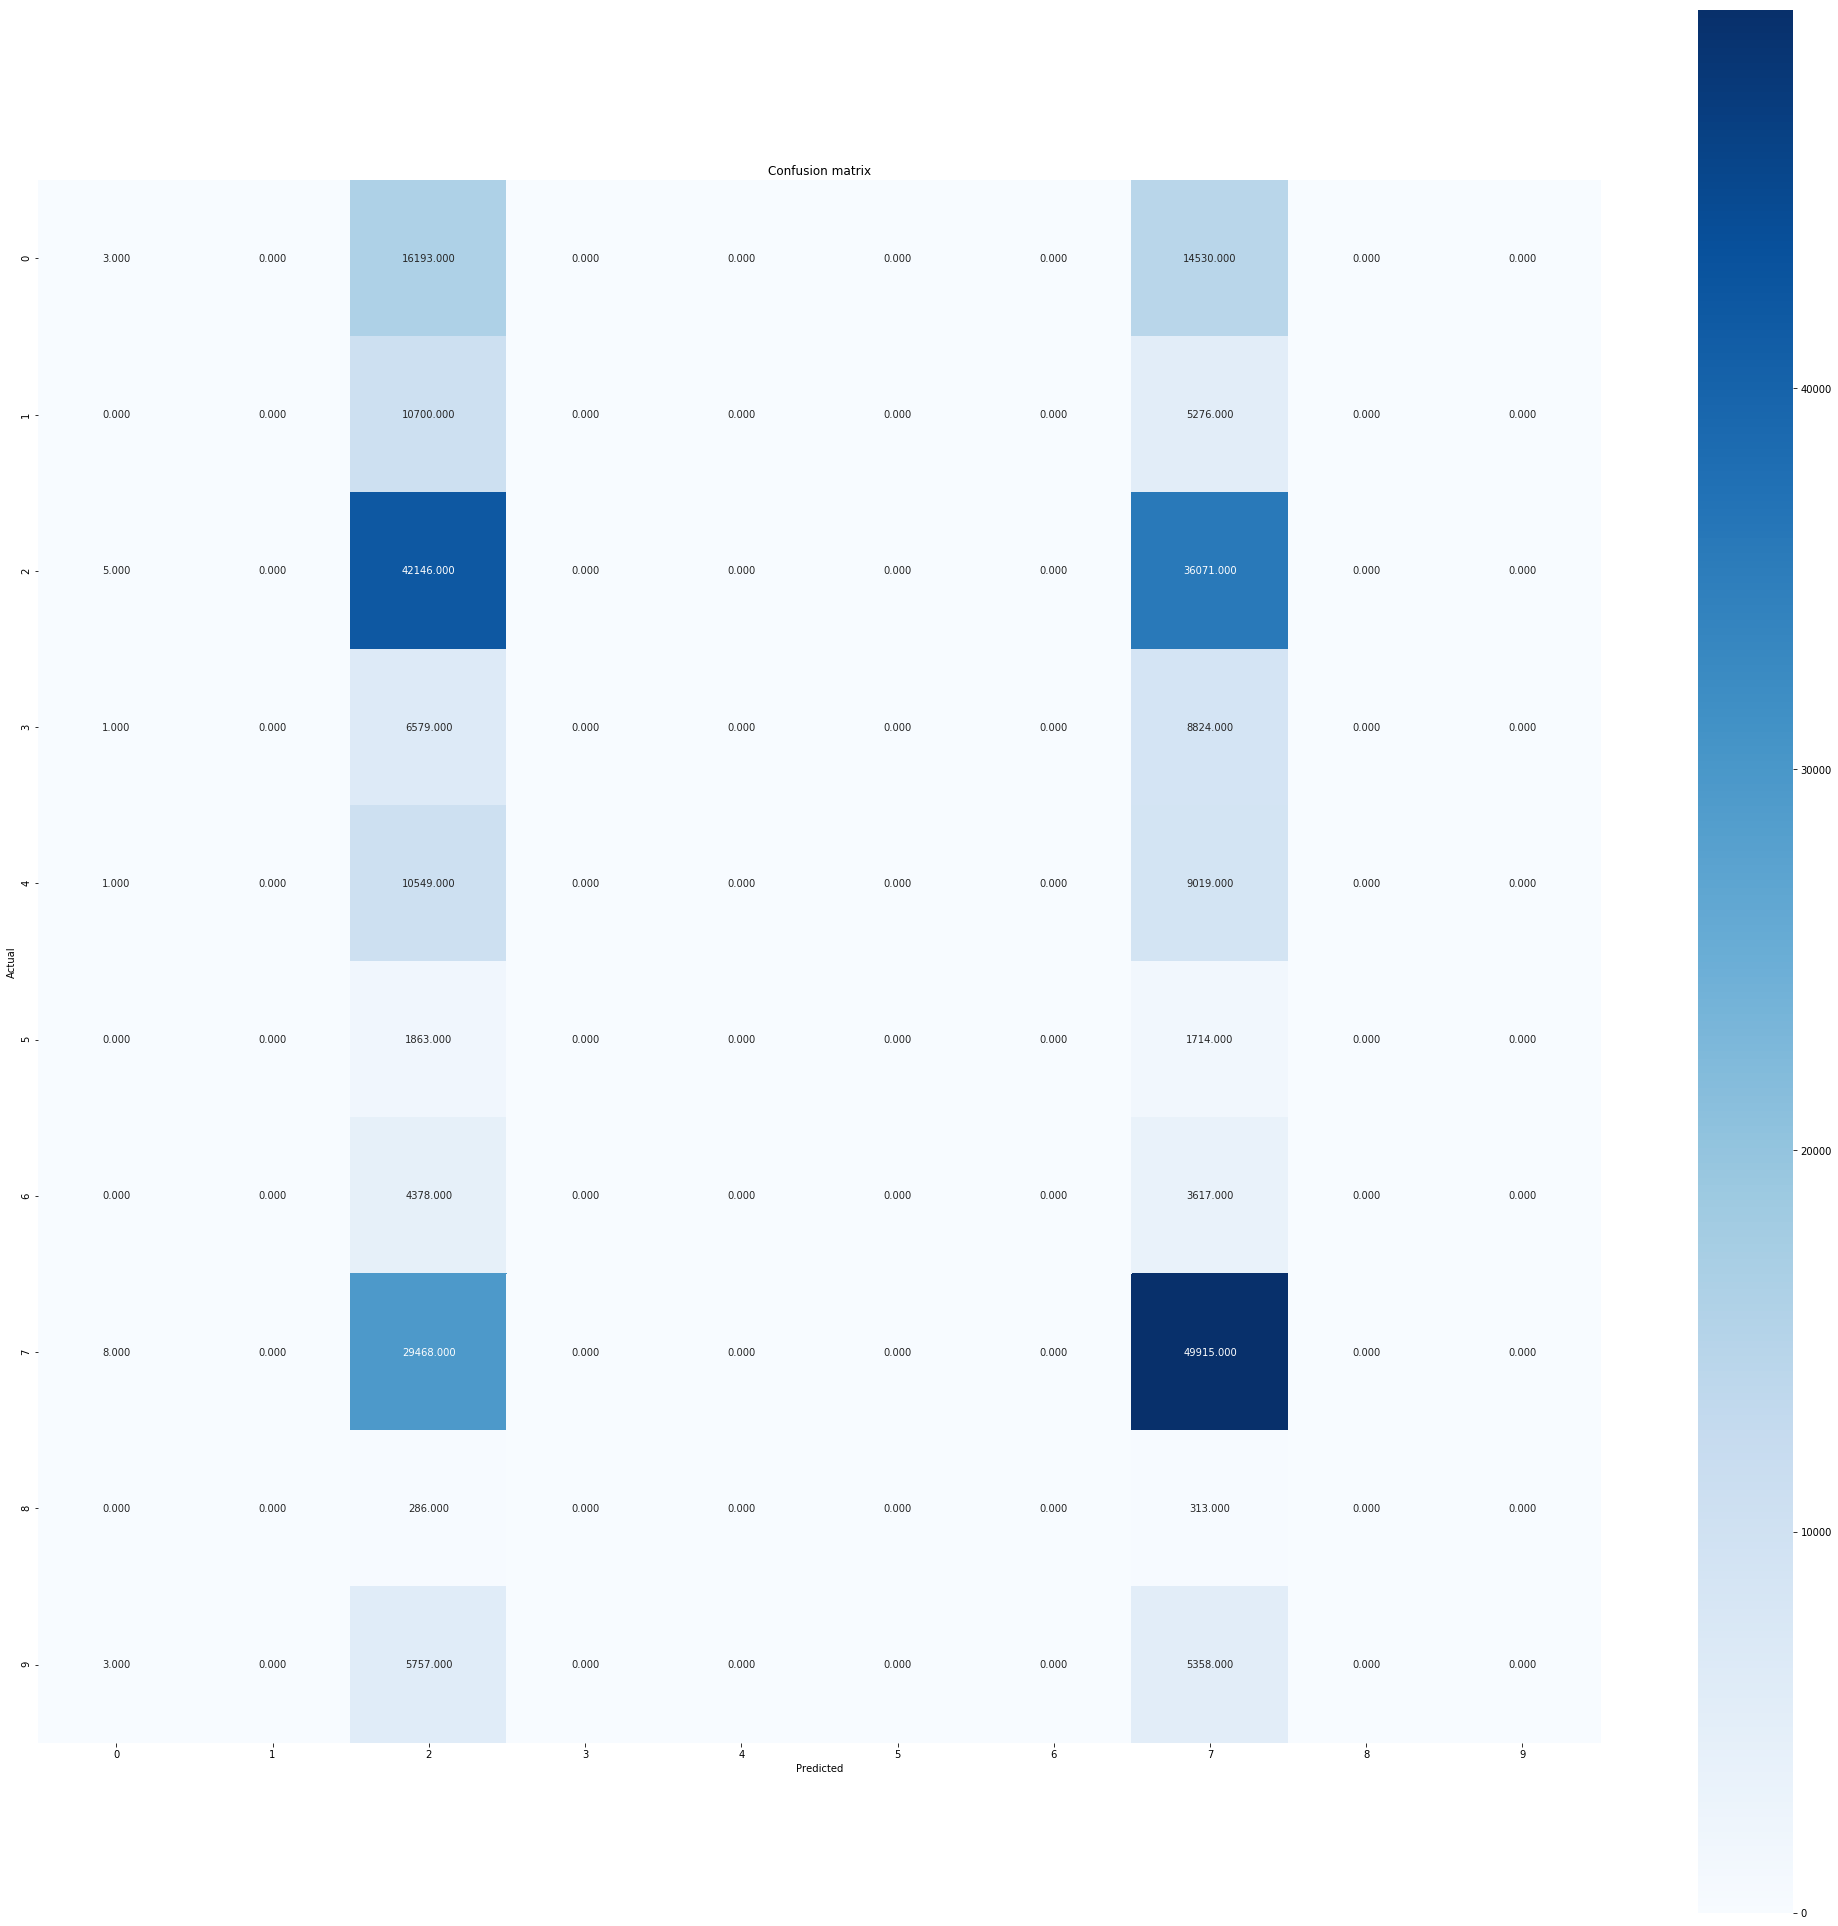

In [73]:
# plot confusion matrix
plt.subplots(figsize=(35,35))
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

In [74]:
# compute evaluation metrics
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.3506171523019914
0.6493828476980086
0.31642295565768586
0.4888206903509098
0.36647755221217937


# Decision Tree Using boosting

In [75]:
# CLASSIFIER: Ensemble of decision trees (with boosting)
model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = "entropy", random_state = 0), n_estimators = 256, random_state = 0)
model.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=1.0, n_estimators=256, random_state=0)

In [76]:
# compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[    3     0 16193     0     0     0     0 14530     0     0]
 [    0     0 10700     0     0     0     0  5276     0     0]
 [    5     0 42146     0     0     0     0 36071     0     0]
 [    1     0  6579     0     0     0     0  8824     0     0]
 [    1     0 10549     0     0     0     0  9019     0     0]
 [    0     0  1863     0     0     0     0  1714     0     0]
 [    0     0  4378     0     0     0     0  3617     0     0]
 [    8     0 29468     0     0     0     0 49915     0     0]
 [    0     0   286     0     0     0     0   313     0     0]
 [    3     0  5757     0     0     0     0  5358     0     0]]


Text(0.5,1,'Confusion matrix')

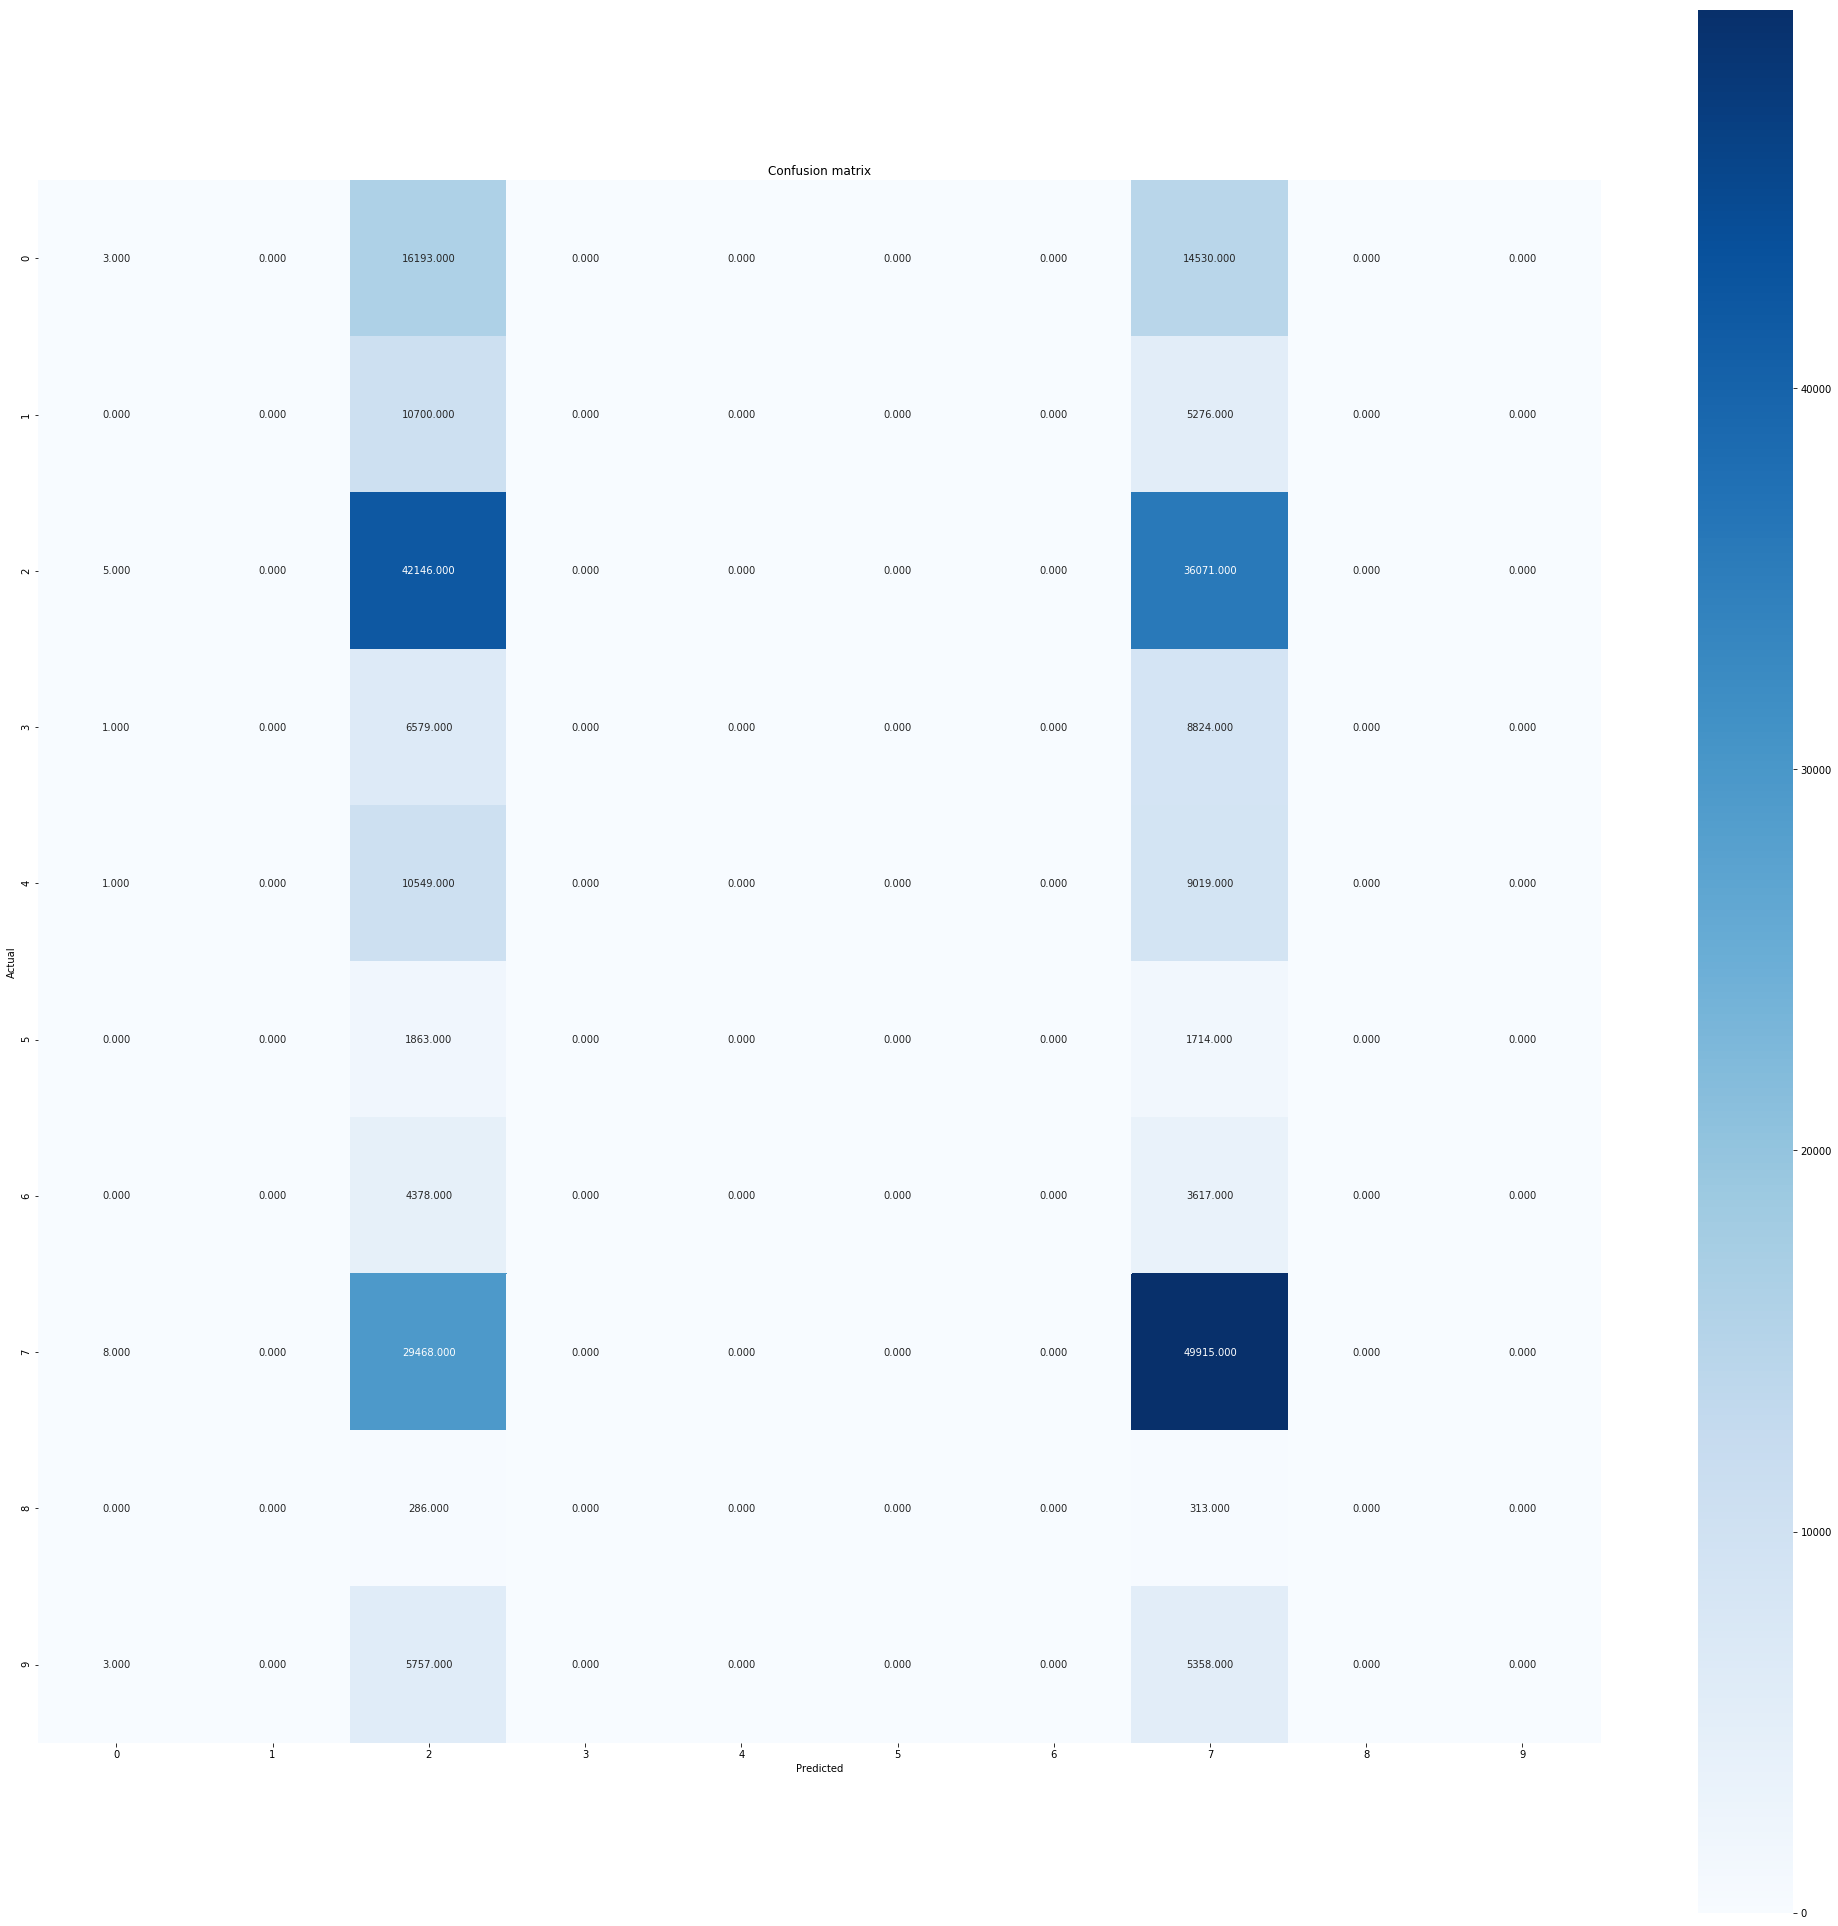

In [77]:
# plot confusion matrix
plt.subplots(figsize=(35,35))
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

In [78]:
# compute evaluation metrics
print(metrics.accuracy_score(y_test, y_pred)) # accuracy
print(1 - metrics.accuracy_score(y_test, y_pred)) # error
print(metrics.precision_score(y_test, y_pred,average = 'weighted',labels=np.unique(y_pred))) # precision
print(metrics.recall_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # recall
print(metrics.f1_score(y_test, y_pred, average = 'weighted',labels=np.unique(y_pred))) # F1 score

0.3506171523019914
0.6493828476980086
0.31642295565768586
0.4888206903509098
0.36647755221217937


# Clustering

In [79]:
# factorize class labels
factor = pd.factorize(train_data['Category'])
print(factor[0])
train_data['Category'] = factor[0]

[ 0  1  1 ...  2  4 12]


In [80]:
# Encoding Sessions 
day_session = preprocessing.LabelEncoder()
day_session.fit(train_data.Day_Sessions)
train_data.Day_Sessions = day_session.transform(train_data.Day_Sessions)

In [81]:
train_data['Category'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int64)

In [82]:
# Selecting the features for Clustering
X = train_data[['Day','Year','Day_Sessions']]
Y = train_data['Category']

# K-Means clustering

In [83]:
# CLUSTERING: K-Means clustering (random initialization, single iteration)
clustering = KMeans(n_clusters = 39, init = 'random', n_init = 1, random_state = 2).fit(X)

In [84]:
# show centroids
clustering.cluster_centers_

array([[2.65325031e+01, 2.00415314e+03, 1.80207335e+00],
       [2.90051599e+01, 2.00731907e+03, 5.45809084e-01],
       [1.11706705e+01, 2.00688297e+03, 2.65590931e+00],
       [8.32918599e+00, 2.00920761e+03, 8.49410036e-01],
       [1.78003428e+01, 2.01365913e+03, 9.12660191e-01],
       [1.55675533e+01, 2.01102289e+03, 2.56106921e+00],
       [5.58752301e+00, 2.01104369e+03, 1.75070567e+00],
       [5.44714350e+00, 2.01380627e+03, 1.77241715e+00],
       [2.51559470e+01, 2.00710937e+03, 1.72156337e+00],
       [1.36005891e+01, 2.01342924e+03, 1.60008416e+00],
       [9.27605592e+00, 2.01337577e+03, 1.57108514e+00],
       [2.62235146e+01, 2.01318594e+03, 1.13094048e+00],
       [1.07772046e+01, 2.01075926e+03, 3.27900478e+00],
       [2.75963859e+01, 2.01025041e+03, 7.95773354e-01],
       [2.90436098e+01, 2.00849495e+03, 3.13966007e+00],
       [2.28731997e+01, 2.00434829e+03, 1.70148478e+00],
       [2.15304025e+01, 2.00815094e+03, 1.76276838e+00],
       [2.03308311e+00, 2.00967

In [85]:
# show clusters
clusters = clustering.labels_
print(clusters)

[ 9  9  9 ... 33 33 33]


Text(0.5,1,'Confusion matrix')

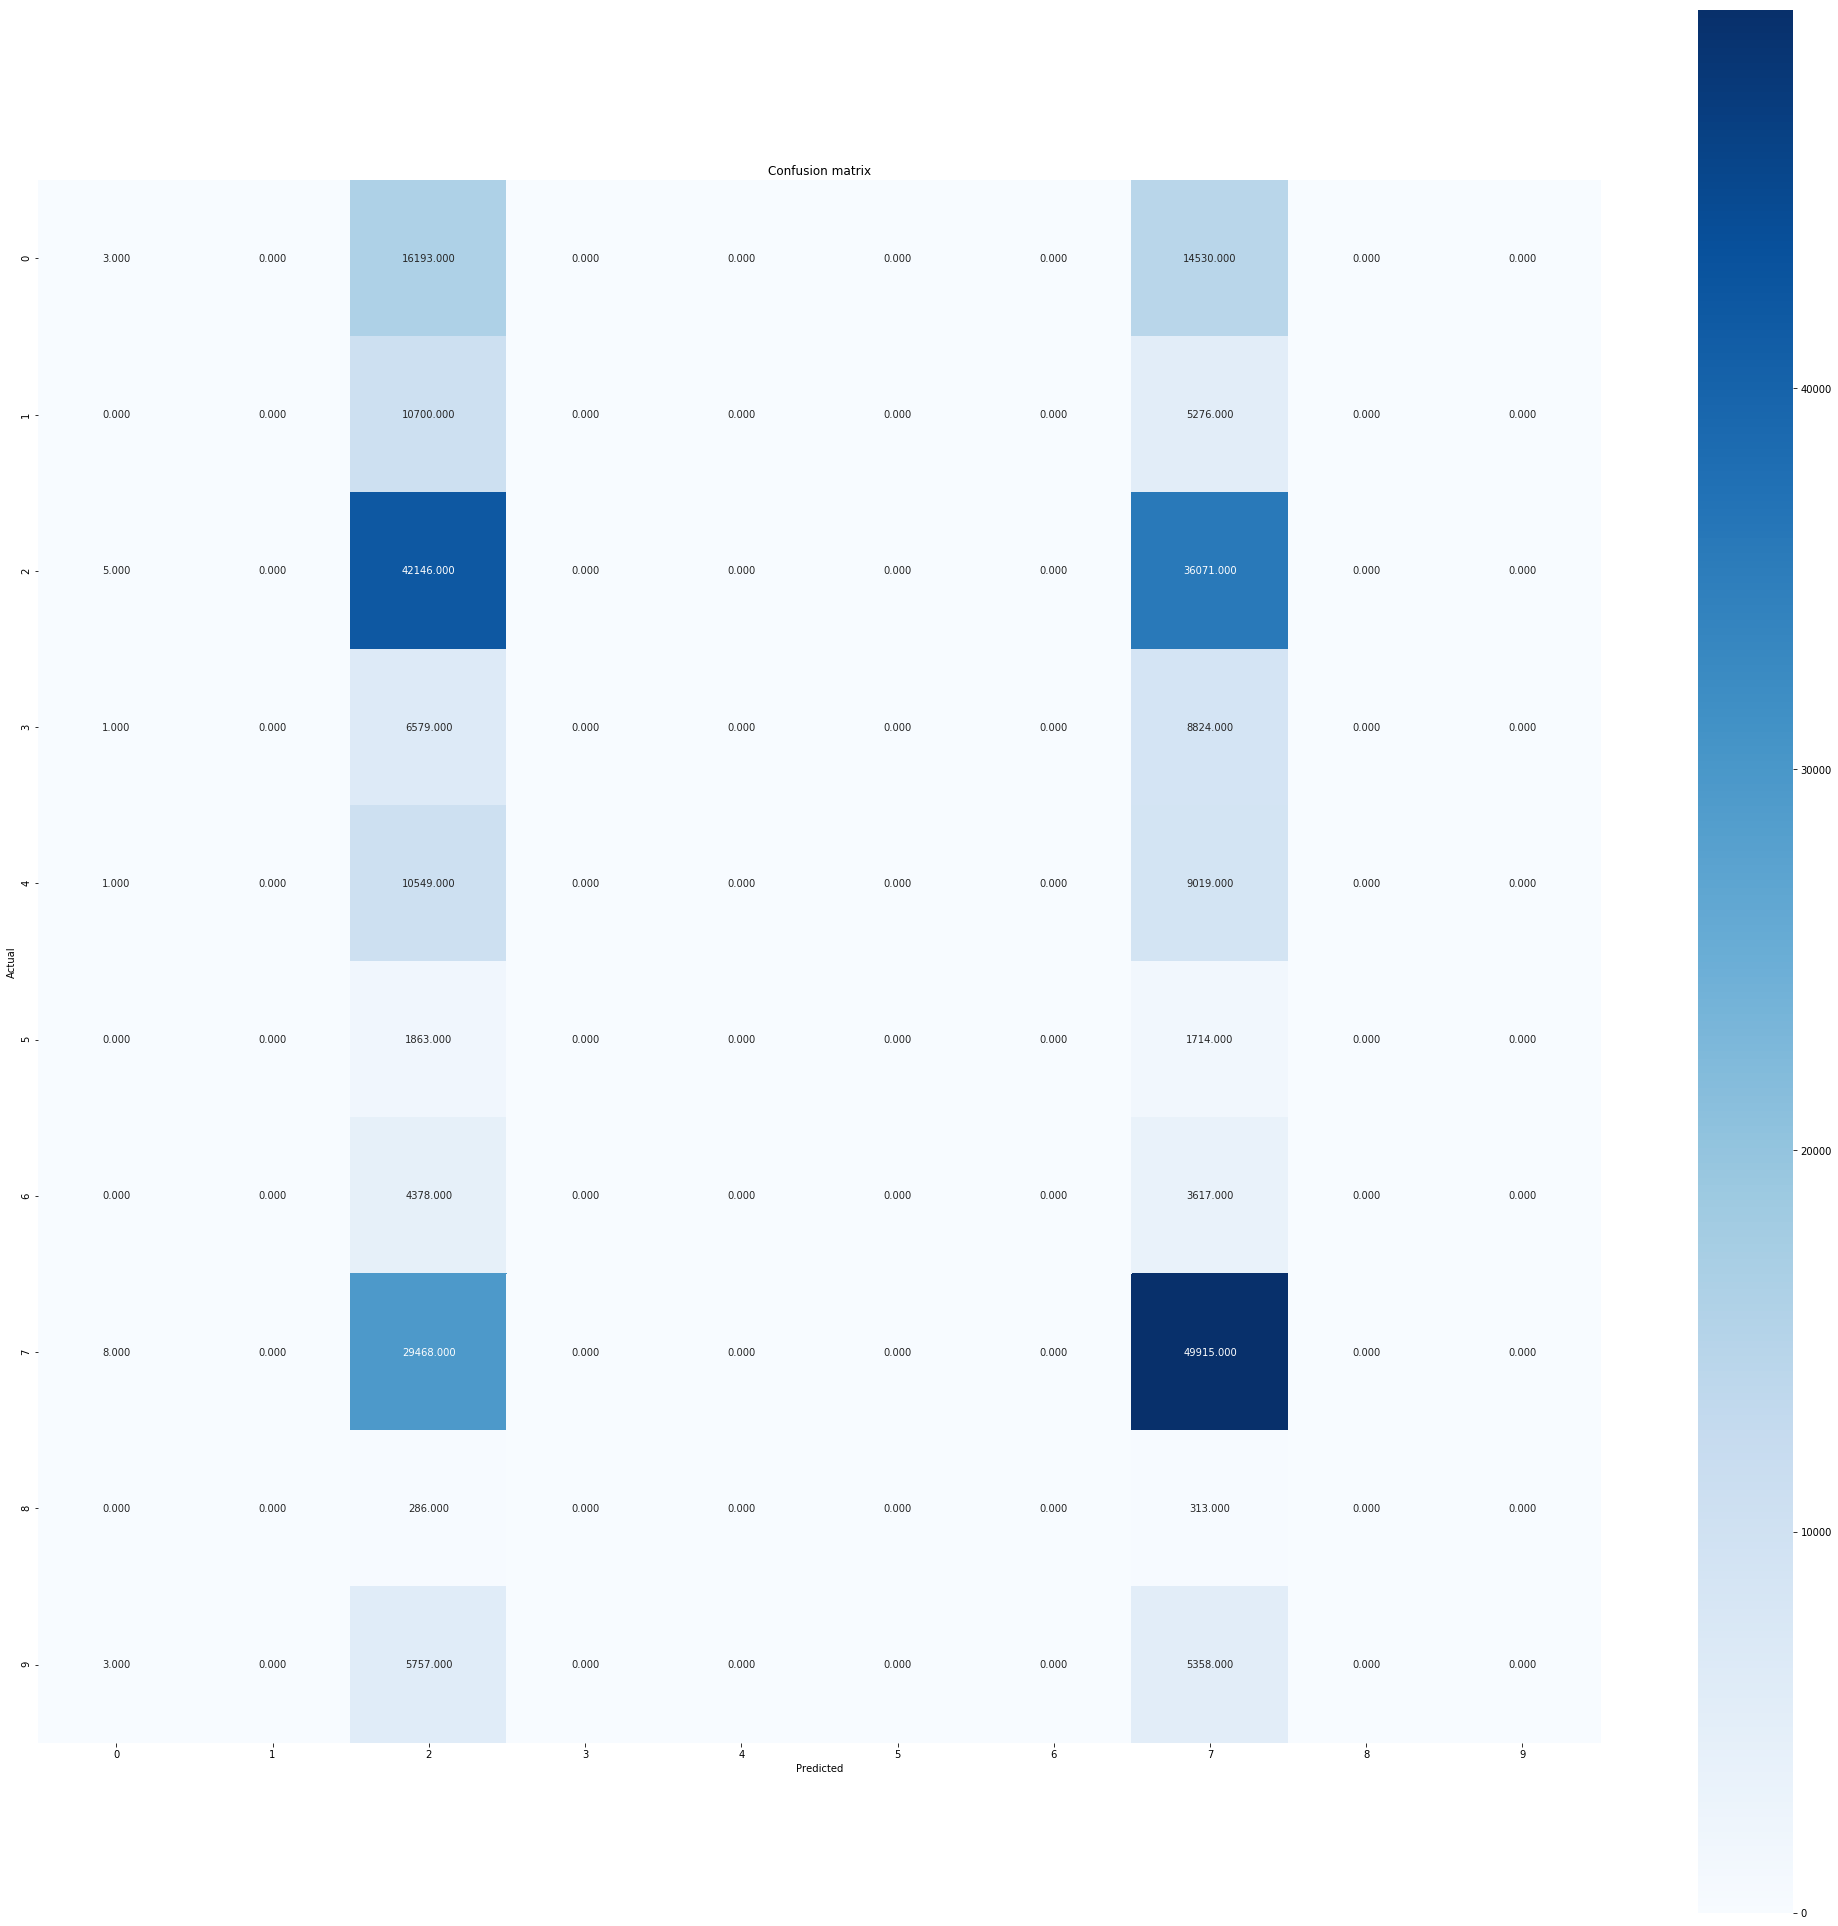

In [86]:
# plot contingency matrix
plt.subplots(figsize=(35,35))
cont_matrix = metrics.cluster.contingency_matrix(train_data['Category'], clusters)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

In [87]:
# compute adjusted Rand index
print(metrics.adjusted_rand_score(train_data['Category'], clusters))

0.0012955798837019816


In [88]:
# compute normalized mutual information
print(metrics.normalized_mutual_info_score(train_data['Category'], clusters))

C:\Program Files\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:605: RuntimeWarning:

invalid value encountered in log



nan


# K++

In [ ]:
# CLUSTERING: K-Means clustering (k-means++ initialization, multiple iterations)
clustering = KMeans(n_clusters = 39, init = 'k-means++', n_init = 10).fit(X)

In [ ]:
# show centroids
clustering.cluster_centers_

In [ ]:
# show clusters
clusters = clustering.labels_
print(clusters)

In [ ]:
# plot contingency matrix
plt.subplots(figsize=(35,35))
cont_matrix = metrics.cluster.contingency_matrix(train_data['Category'], clusters)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')

In [ ]:
# compute adjusted Rand index
print(metrics.adjusted_rand_score(train_data['Category'], clusters))

In [ ]:
# compute normalized mutual information
print(metrics.normalized_mutual_info_score(train_data['Category'], clusters))

In [ ]:
# plot contingency matrix
plt.subplots(figsize=(35,35))
cont_matrix = metrics.cluster.contingency_matrix(train_data['Category'], clusters)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')